<a href="https://colab.research.google.com/github/MDankloff/ScriptAIRbnb.R/blob/main/Selma2_3_compas_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Used tutorials:
- https://towardsdatascience.com/compas-case-study-fairness-of-a-machine-learning-model-f0f804108751

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# import shap
# import gc

# from lightgbm import LGBMClassifier
# import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
warnings.simplefilter(action='ignore', category=FutureWarning)


for dirname, _, filenames in os.walk('/compas_archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
#import pandas as pd
# compas_scores_raw = pd.read_csv("compas_archive/compas-scores-raw.csv")
# cox_violent_parsed = pd.read_csv("compas_archive/cox-violent-parsed.csv")
# cox_violent_parsed_filt = pd.read_csv("compas_archive/cox-violent-parsed_filt.csv")

import pandas as pd
compas_scores_raw = pd.read_csv("/content/compas-scores-raw.csv")
cox_violent_parsed = pd.read_csv("/content/cox-violent-parsed.csv")
cox_violent_parsed_filt = pd.read_csv("/content/cox-violent-parsed_filt.csv")

In [8]:
TARGET_COL = "Two_yr_Recidivism"

In [11]:
#df = pd.read_csv("compas_archive/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")
df = pd.read_csv("/content/propublica_data_for_fairml.csv")
df.info()
display(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

In [12]:
X = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

In [13]:
# Splitting X and y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y)


In [14]:
# Training a RandomForest Classifier
# model = RandomForestClassifier()
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Obtaining predictions
y_hat = model.predict(X_test)
len(y_hat)

1852

In [15]:
# Converting y_hat from Np to DF
predictions_col = pd.DataFrame()
predictions_col['predicted_class'] = y_hat.tolist()
predictions_col = predictions_col.set_index(X_test.index)
predictions_col['true_class'] = y_test

# Calculating the errors with the absolute value
predictions_col['errors'] = abs(predictions_col['predicted_class'] - predictions_col['true_class'])


# Rescaling the prediction errors with max error value of 1
# It doesn't matter whether the misclassification is between class 0 and 2 or between 0 and 1, it has the same error value.
predictions_col['errors'] = predictions_col['errors'].replace(2.0, 1.0)
# print(len(predictions_col['errors'] ))

# Adding predictions to test data
entire_dataset = X_test.merge(predictions_col, how='outer', left_index = True, right_index = True)


errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)

# The dataset
print(len(entire_dataset))
entire_dataset[entire_dataset['errors']==1]

1852


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors
2182,5,0,0,0,0,0,0,0,0,0,1,1,0,1
2208,1,1,0,1,1,0,0,0,0,0,0,1,0,1
4020,2,1,0,0,1,0,0,0,0,0,0,0,1,1
2718,3,0,0,0,1,0,0,0,0,1,0,1,0,1
2707,4,1,0,0,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,2,0,1,0,1,0,0,0,0,1,0,1,0,1
3413,4,0,0,0,1,0,0,0,0,0,0,1,0,1
3926,12,1,1,0,1,0,0,0,0,0,1,0,1,1
4801,0,0,0,0,0,0,0,0,0,0,1,0,1,1


In [16]:
errors = len(entire_dataset.loc[entire_dataset['errors']==1])
correct = len(entire_dataset.loc[entire_dataset['errors']==0])

print(correct)
print(errors)

print(accuracy_score(y_test,y_hat))

1249
603
0.6744060475161987


Text(0, 0.5, 'Recidivism rate')

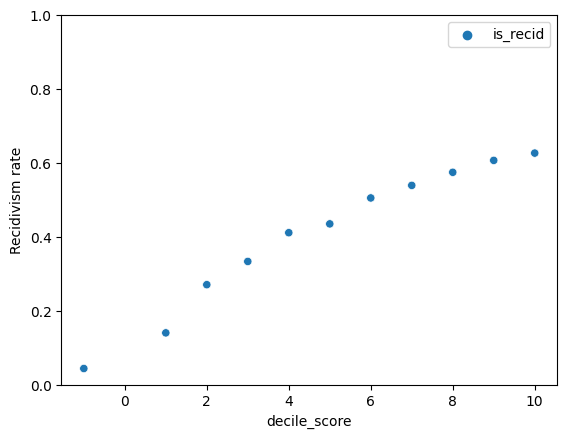

In [25]:
#Mirthe's addition: decile score and is_recid - other two columns not found in fairml dataset
d = cox_violent_parsed_filt.groupby('decile_score').agg({'is_recid':'mean'})

sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate')

In [17]:
d = df.groupby('decile_score').agg({'two_year_recid': 'mean'})
# plot


sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate');

KeyError: ignored

In [34]:
# Mirthe addtion: decile score not found in original used fairml data set
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(cox_violent_parsed_filt['is_recid'], cox_violent_parsed_filt['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");

KeyError: ignored

In [33]:

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");

KeyError: ignored

In [31]:
entire_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852 entries, 2182 to 4038
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Number_of_Priors      1852 non-null   int64
 1   score_factor          1852 non-null   int64
 2   Age_Above_FourtyFive  1852 non-null   int64
 3   Age_Below_TwentyFive  1852 non-null   int64
 4   African_American      1852 non-null   int64
 5   Asian                 1852 non-null   int64
 6   Hispanic              1852 non-null   int64
 7   Native_American       1852 non-null   int64
 8   Other                 1852 non-null   int64
 9   Female                1852 non-null   int64
 10  Misdemeanor           1852 non-null   int64
 11  predicted_class       1852 non-null   int64
 12  true_class            1852 non-null   int64
 13  errors                1852 non-null   int64
dtypes: int64(14)
memory usage: 281.6 KB


In [32]:
# Exporting the preprocessed dataset
import os
path = r'..\\Preprocessed_datasets\\'
# entire_dataset.to_csv(os.path.join(path, r'final_preprocessed_compas.csv'))

